Initial Shape: (268947, 14)
Columns: ['OBJECTID', 'uuid', 'City', 'Surface_area', 'Potential_installable_area', 'Peak_installable_capacity', 'Energy_potential_per_year', 'Assumed_building_type', 'Estimated_tilt', 'Estimated_building_height', 'Estimated_capacity_factor', 'Date_added', 'Comment', 'Unit_installation_price']

Shape after dropping empty cols: (268947, 11)

Missing Values Summary:
 OBJECTID                         0
uuid                             0
City                             0
Surface_area                     0
Potential_installable_area       0
Peak_installable_capacity        0
Energy_potential_per_year        0
Assumed_building_type            0
Estimated_tilt                   0
Estimated_building_height      992
Estimated_capacity_factor     3834
dtype: int64

Data Types:
 OBJECTID                        int64
uuid                           object
City                           object
Surface_area                  float64
Potential_installable_area    float64
Pe

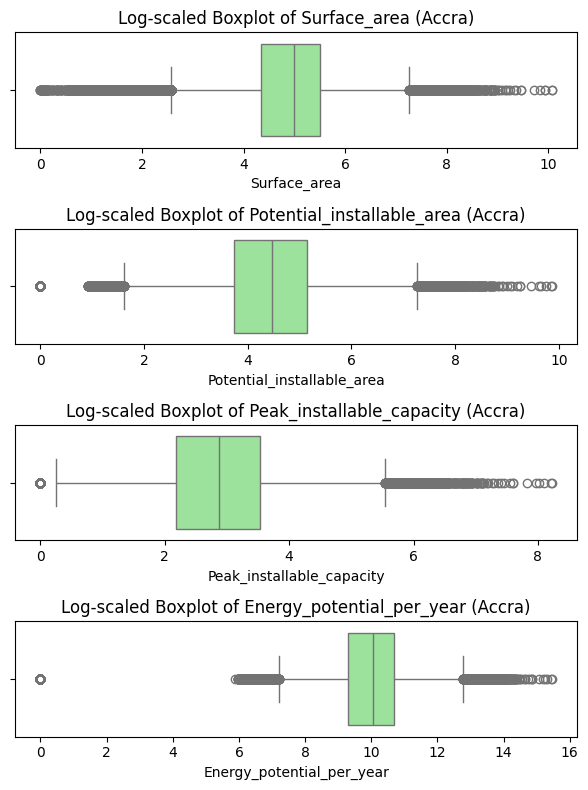


Outlier Summary (99th percentile cutoff):
                       Feature  99th_percentile  Outlier_count  Outlier_%
0                Surface_area       847.859380           2690   1.000197
1  Potential_installable_area       617.428815           2690   1.000197
2   Peak_installable_capacity       119.847797           2690   1.000197
3   Energy_potential_per_year    166541.479375           2690   1.000197

Outlier Building Types:
 Assumed_building_type
industrial                   787
public                       750
commercial                   747
single family residential    465
multi-family residential      88
Name: count, dtype: int64

Normal Building Types:
 Assumed_building_type
single family residential    229637
commercial                    19817
public                        11797
multi-family residential       2451
industrial                     2408
Name: count, dtype: int64
Surface_area: 4 zeros (0.00%)
Potential_installable_area: 3834 zeros (1.43%)
Peak_installable_capac

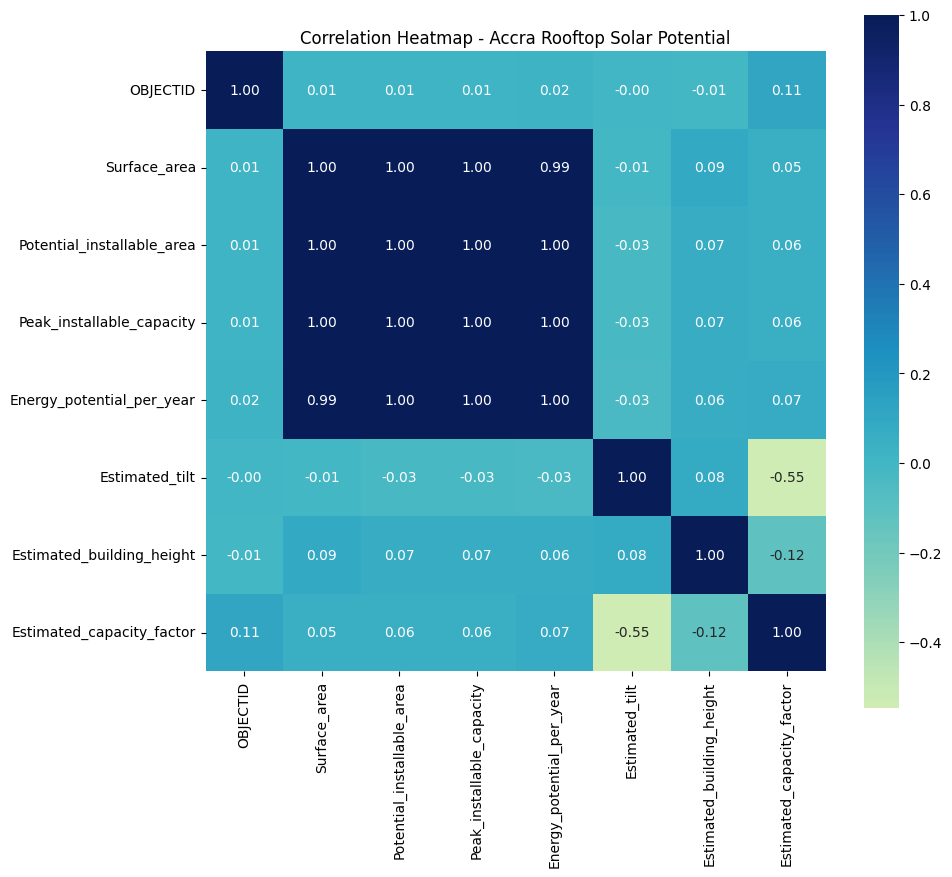

In [1]:
# ======================
# EDA – Rooftop Solar Potential (Accra)
# ======================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("datasets/accra_rooftop_solarpotential.csv")

print("Initial Shape:", df.shape)
print("Columns:", df.columns.tolist())

# --- Drop fully empty columns ---
df = df.drop(columns=['Unit_installation_price', 'Date_added', 'roof_quality', 'Comment'], errors='ignore')
print("\nShape after dropping empty cols:", df.shape)

# --- Missing values summary ---
print("\nMissing Values Summary:\n", df.isna().sum())
print("\nData Types:\n", df.dtypes)

# --- Descriptive statistics ---
print("\nDescriptive Statistics:\n", df.describe().T)

# --- Log-scaled boxplots for key numerical columns ---
numeric_cols = ['Surface_area', 'Potential_installable_area',
                'Peak_installable_capacity', 'Energy_potential_per_year']
plt.figure(figsize=(6, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=np.log1p(df[col]), color='lightgreen')
    plt.title(f'Log-scaled Boxplot of {col} (Accra)')
plt.tight_layout()
plt.show()

# --- Outlier detection (99th percentile) ---
outlier_stats = []
for col in numeric_cols:
    q99 = df[col].quantile(0.99)
    outliers = (df[col] > q99).sum()
    outlier_stats.append([col, q99, outliers, outliers / len(df) * 100])
outlier_df = pd.DataFrame(outlier_stats, columns=['Feature', '99th_percentile', 'Outlier_count', 'Outlier_%'])
print("\nOutlier Summary (99th percentile cutoff):\n", outlier_df)

# --- Outlier building type analysis ---
outlier_mask = (df['Surface_area'] > df['Surface_area'].quantile(0.99)) | \
               (df['Potential_installable_area'] > df['Potential_installable_area'].quantile(0.99))
print("\nOutlier Building Types:\n", df.loc[outlier_mask, 'Assumed_building_type'].value_counts())
print("\nNormal Building Types:\n", df.loc[~outlier_mask, 'Assumed_building_type'].value_counts())

# --- Zero check ---
for col in numeric_cols:
    zeros = (df[col] == 0).sum()
    print(f"{col}: {zeros} zeros ({zeros/len(df)*100:.2f}%)")

# --- Filter out zero-value rows for correlation ---
df_nozero = df[
    (df['Potential_installable_area'] > 0) &
    (df['Peak_installable_capacity'] > 0) &
    (df['Energy_potential_per_year'] > 0)
].copy()

print("\nFiltered Shape (no zeros):", df_nozero.shape)

# --- Correlation heatmap ---
corr = df_nozero.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(10, 9))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='YlGnBu', center=0, square=True)
plt.title("Correlation Heatmap - Accra Rooftop Solar Potential")
plt.show()


🧩 Step 9 Analysis – Accra Rooftop Solar Potential
🧱 1. General structure

268,947 rows, which is the largest dataset so far → meaning more coverage (city-wide survey).

Missing values:

Estimated_building_height → ~1,000 missing (negligible)

Estimated_capacity_factor → ~3,800 missing (~1.4 %)
So quality is still high.

📊 2. Descriptive stats & distribution
| Feature                        |    Median    | Comment                                                                                           |
| :----------------------------- | :----------: | :------------------------------------------------------------------------------------------------ |
| **Surface_area**               |    ~148 m²   | Consistent with previous cities — mainly small/medium rooftops                                    |
| **Potential_installable_area** |    ~87 m²    | Around 60 % of roof usable (good ratio)                                                           |
| **Energy_potential_per_year**  |    ~23 MWh   | Slightly *higher* than Tegucigalpa & San Pedro Sula → consistent with Ghana’s stronger irradiance |
| **Estimated_tilt**             |  Mean ≈ 12°  | Flat rooftops dominant; low tilt matches tropical designs                                         |
| **Estimated_capacity_factor**  | Mean ≈ 1,378 | Slightly lower spread (std ≈ 45) → more uniform irradiance conditions                             |

📦 3. Boxplots (log-scaled)

Still long right tails → a few large commercial roofs.

Fewer extreme high-end points than in Tegucigalpa (the spread is tighter).

Strong left-side “zero zone” (we’ll confirm zeros soon).

Interpretation: Accra’s distribution is healthier and less skewed → more consistent rooftop geometry.

📈 4. Correlation heatmap
| Relationship                              |       Correlation       | Note                                                                      |
| :---------------------------------------- | :---------------------: | :------------------------------------------------------------------------ |
| Area ↔ Capacity ↔ Energy                  |        ~0.99–1.00       | Perfect internal scaling, same as before.                                 |
| Tilt ↔ Capacity Factor                    |          −0.55          | Repeats physical pattern: steep tilt reduces effective solar performance. |
| Height ↔ Area / Energy                    | Very weak (≈ 0.06–0.09) | Height has minimal role in solar potential (expected).                    |
| Capacity Factor ↔ Installation Efficiency |          +0.12          | Slight positive coupling — efficient setups in stable-sunlight areas.     |

So, correlation patterns remain similar across countries, proving dataset consistency — but tilt impact is milder (−0.55 vs −0.59 in San Pedro Sula).

☀️ 5. Key takeaways for report notes

Dataset size: ~269 k buildings (largest so far).

Strong linear relationship among physical variables.

Lower tilt & uniform capacity factors → consistent tropical irradiance.

Outlier tail smaller — fewer extremely large roofs.

Excellent candidate for modeling (minimal missing data, consistent scaling).

In [2]:
# Step 10: Count zeros in key metrics
for col in ['Potential_installable_area', 'Peak_installable_capacity', 'Energy_potential_per_year']:
    zeros = (df[col] == 0).sum()
    print(f"{col}: {zeros} zeros ({zeros/len(df)*100:.2f}%)")

Potential_installable_area: 3834 zeros (1.43%)
Peak_installable_capacity: 3834 zeros (1.43%)
Energy_potential_per_year: 3834 zeros (1.43%)


In [3]:
# Step 11: 99th percentile outlier mask and type counts
outlier_mask = (
    (df['Surface_area'] > df['Surface_area'].quantile(0.99)) |
    (df['Potential_installable_area'] > df['Potential_installable_area'].quantile(0.99))
)
print("\nOutlier Building Types:\n", df.loc[outlier_mask, 'Assumed_building_type'].value_counts())
print("\nNormal (non-outlier) Building Types:\n", df.loc[~outlier_mask, 'Assumed_building_type'].value_counts())


Outlier Building Types:
 Assumed_building_type
industrial                   787
public                       750
commercial                   747
single family residential    465
multi-family residential      88
Name: count, dtype: int64

Normal (non-outlier) Building Types:
 Assumed_building_type
single family residential    229637
commercial                    19817
public                        11797
multi-family residential       2451
industrial                     2408
Name: count, dtype: int64


🧩 Step 10–11 Analysis – Accra Zero Values & Outlier Types
🔹 Zero-value summary
| Metric                     | Zero Count | % of Dataset | Interpretation                                                       |
| :------------------------- | ---------: | -----------: | :------------------------------------------------------------------- |
| Potential_installable_area |      3,834 |        1.43% | Roofs not suitable for installation (shading, small, or obstructed). |
| Peak_installable_capacity  |      3,834 |        1.43% | No usable solar space, so no capacity.                               |
| Energy_potential_per_year  |      3,834 |        1.43% | Zero energy yield → physically meaningful zeros.                     |

Interpretation:
Almost identical to San Pedro Sula (1.41 %), showing strong consistency in how unusable roofs were classified. These zeros are valid physical constraints, not data errors — keep them for coverage reporting, but exclude from modeling/correlation.

🔹 Outlier building types (top 1 %)
| Category                      | Outlier Count | Normal Count | Observation                                                                 |
| :---------------------------- | ------------: | -----------: | :-------------------------------------------------------------------------- |
| **Industrial**                |           787 |        2,408 | Largest single contributor to outliers → very large factories / warehouses. |
| **Public**                    |           750 |        2,408 | Government or utility buildings with large flat roofs.                      |
| **Commercial**                |           747 |       19,817 | Consistent with expected large retail or office spaces.                     |
| **Single-family residential** |           465 |      229,637 | Only a small portion of homes appear in top 1 %.                            |
| **Multi-family residential**  |            88 |        2,451 | Small but present share of apartment blocks.                                |

🧠 Interpretation Summary

Outliers are dominated by industrial and public structures, which is expected for high-capacity buildings.

This validates that the large values in boxplots and tails are not data errors — they’re real, physically plausible large rooftops.

The 1.43 % zero group represents unfit roofs, and the 1 % outlier group captures top-capacity sites — both ends are meaningful and shouldn’t be blindly dropped.